In [1]:
!pip install torcheval
!pip install icrawler
!pip install torchmetrics
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 870.5/870.5 kB 14.2 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset
import matplotlib.patches as patches
from torch.utils.data import DataLoader
import random
import torch.optim as optim
from ultralytics import YOLO
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import cv2
from icrawler.builtin import GoogleImageCrawler
from torcheval.metrics.functional import multiclass_f1_score, multiclass_precision, multiclass_recall
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import torchvision
from google.colab import drive
drive.mount('/content/drive')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Mounted at /content/drive


In [3]:
# Working with drive, because I have to save the data
drive_path = '/content/drive/My Drive/DND_assignment_1'

In [4]:
# Here I read the saved images and crop them according to their size
data_dir = os.path.join(drive_path, 'pics')
images = []
labels = []
for image_name in os.listdir(data_dir):
    image_path = os.path.join(data_dir, image_name)
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        cropped_image = image[y:y+h, x:x+w]
        images.append(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
        labels.append(image_name.split('.')[0])
labels = sorted(labels)

In [5]:
# 3 image sizes, the categories are: ball, boot, trophy
[x.shape for x in images], labels

([(486, 496, 3), (456, 163, 3), (470, 1190, 3)], ['ball', 'boot', 'trophy'])

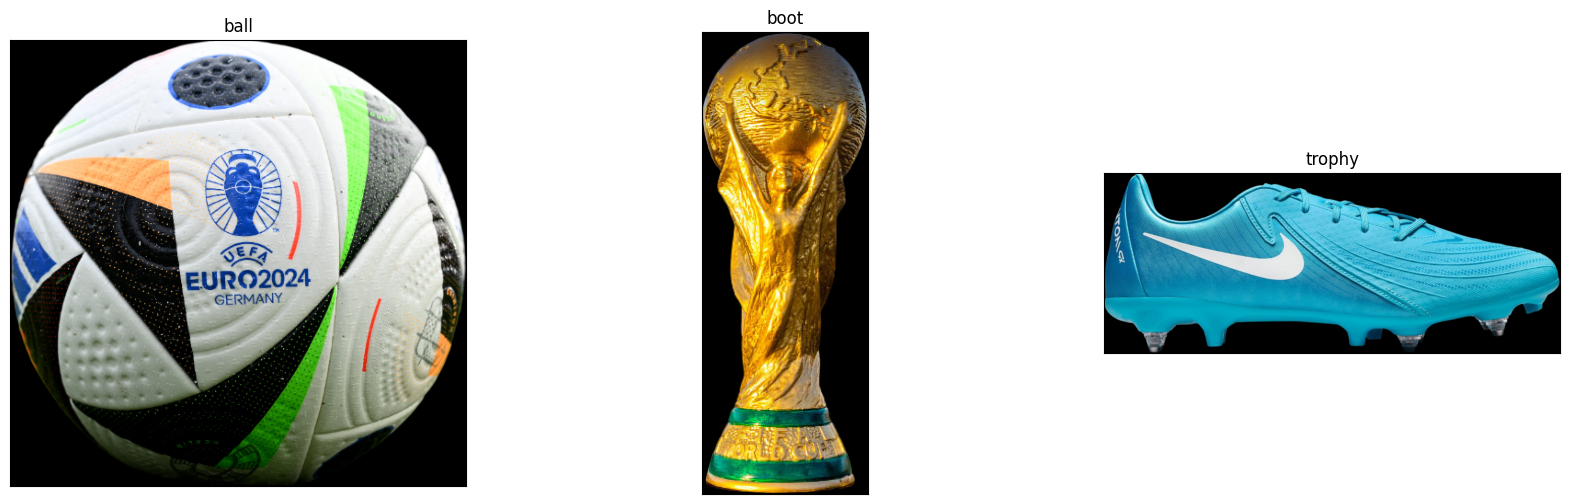

In [6]:
# Showing the object images
fig, axes = plt.subplots(1,len(images), figsize=(20,6))
for i, image in enumerate(images):
    axes[i].imshow(image)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(labels[i])
plt.show()

In [7]:
# Creating a dict from the objects, that I can track their indices later
classes_dict = {}
for i, label in enumerate(sorted(labels)):
    classes_dict[i] = label
classes_dict

{0: 'ball', 1: 'boot', 2: 'trophy'}

In [8]:
# If background folder does not exist, creating it
background_path = os.path.join(drive_path, 'background')
if not os.path.isdir(background_path):
  os.mkdir(background_path)

In [ ]:
generate_new_backgrounds = False
if generate_new_backgrounds:
  google_crawler = GoogleImageCrawler(
      parser_threads=2,
      downloader_threads=4,
      storage={'root_dir': background_path}
  )

  for keyword in ['budapest', 'budapest parliament', 'buda castle', 'budapest st stephen basilica', 'budapest heroes square']:
      google_crawler.crawl(
          keyword=keyword, max_num=10, file_idx_offset='auto')

In [10]:
# Reading an image
def read_image(directory, image_name):
    path = os.path.join(directory, image_name)
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

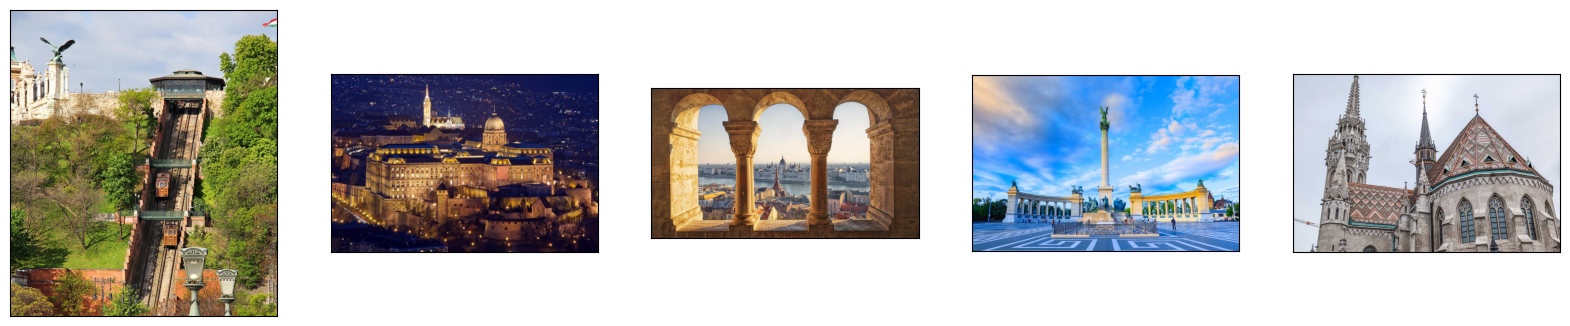

In [11]:
# Show some of the images, to confirm that they were successfully crawled
def display_sample_images(directory):
    backgrounds = os.listdir(directory)
    samples = random.sample(backgrounds, 5)
    _, axes = plt.subplots(1, len(samples), figsize=(20,6))
    for i, sample in enumerate(samples):
        image = read_image(directory, sample)
        axes[i].imshow(image)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    plt.show()
display_sample_images(background_path)

In [12]:
# Adding 0s to the beginning of the filename
def get_file_name(index: int, length=5):
    ind = str(index)
    l = length - len(str(ind))
    return f'{"0" * l}{ind}'

In [13]:
# Size of the dataset images
img_size=(640,640)

In [14]:
# Getting the x, y, w, h numbers to yolo format
def coordinates_to_yolo(x, y, obj_width, obj_height, background_width, background_height):
   return [(x + obj_width/2)/background_width, (y + obj_height/2)/background_height, obj_width/background_width, obj_height/background_height]

In [ ]:
def createDataset(root_dir, dataset_name, split, img_size, num_images):
    # Creating the folders and initializing the path variables
    if not os.path.isdir(root_dir):
        os.mkdir(root_dir)
    path = os.path.join(root_dir, split)
    if not os.path.isdir(path):
        os.mkdir(path)
    images_path = os.path.join(path, 'images')
    labels_path = os.path.join(path, 'labels')
    if not os.path.isdir(images_path):
        os.mkdir(images_path)
    if not os.path.isdir(labels_path): 
        os.mkdir(labels_path)
    # Iterate over the given number of images
    for i in range(num_images):
        # Get a random background
        background = read_image(dataset_name, random.choice(os.listdir(dataset_name)))
        # Get a random object
        ind = random.choice(range(len(images)))
        object = images[ind]
        obj_height, obj_width, _ = object.shape
        background_height, background_width, _ = background.shape
        # Repeating the process until the object fits in the background
        while obj_height > background_height or obj_width > background_width:
            background = read_image(dataset_name, random.choice(os.listdir(dataset_name)))
            ind = random.choice(range(len(images)))
            object = images[ind]
            obj_height, obj_width, _ = object.shape
            background_height, background_width, _ = background.shape
        # Getting a 1 channel image, and crop the object with threshold, threshold_inv is the background of the object
        gray_object = cv2.cvtColor(object, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray_object, 0, 255, cv2.THRESH_BINARY)
        thresh_inv = cv2.bitwise_not(thresh)
        # Getting the random x, y coordinates
        y_range = range(0, background_height - obj_height)
        y_val = random.choice(y_range)
        x_range = range(0, background_width - obj_width)
        x_val = random.choice(x_range)
        # Crop the background and insert the object to it
        roi = background[y_val:y_val+obj_height, x_val:x_val+obj_width]
        background_roi = cv2.bitwise_and(roi, roi, mask=thresh_inv)
        object_foreground = cv2.bitwise_and(object, object, mask=thresh)
        result = cv2.add(background_roi, object_foreground)
        background[y_val:y_val+obj_height, x_val:x_val+obj_width] = result
        # Getting the yolo format
        yolo_bounding_box = coordinates_to_yolo(x_val, y_val, obj_width, obj_height, background_width, background_height)
        # Adding the object's class number
        yolo_bounding_box.insert(0, ind)
        # Resize the image and save it
        background=cv2.resize(background, img_size)
        file_name = get_file_name(i+1)
        image_name = f'{file_name}.jpg'
        label_name = f'{file_name}.txt'
        image_path = os.path.join(images_path, image_name)
        label_path = os.path.join(labels_path, label_name)
        cv2.imwrite(image_path, cv2.cvtColor(background, cv2.COLOR_BGR2RGB))
        with open(label_path, 'w') as f:
            f.write(' '.join(map(str, yolo_bounding_box)))
# I used zipping and unzipping locally because training from drive is really slow
load_dataset = True
if not load_dataset:
  createDataset('dataset', background_path, split='train', img_size=img_size, num_images=5000)
  createDataset('dataset', background_path, split='val', img_size=img_size, num_images=1000)
  createDataset('dataset', background_path, split='test', img_size=img_size, num_images=200)
  !zip -r '/content/drive/My Drive/DND_assignment_1/dataset.zip' '/content/drive/My Drive/DND_assignment_1/dataset/'

!cp '/content/drive/My Drive/DND_assignment_1/dataset.zip' .
!unzip dataset.zip -d .
!mv ./content/drive/My\ Drive/DND_assignment_1/dataset/ ./

Streaming output truncated to the last 5000 lines.
  inflating: ./content/drive/My Drive/DND_assignment_1/dataset/train/labels/02414.txt  
  inflating: ./content/drive/My Drive/DND_assignment_1/dataset/train/labels/02415.txt  
  inflating: ./content/drive/My Drive/DND_assignment_1/dataset/train/labels/02416.txt  
  inflating: ./content/drive/My Drive/DND_assignment_1/dataset/train/labels/02417.txt  
  inflating: ./content/drive/My Drive/DND_assignment_1/dataset/train/labels/02418.txt  
  inflating: ./content/drive/My Drive/DND_assignment_1/dataset/train/labels/02419.txt  
  inflating: ./content/drive/My Drive/DND_assignment_1/dataset/train/labels/02420.txt  
  inflating: ./content/drive/My Drive/DND_assignment_1/dataset/train/labels/02421.txt  
  inflating: ./content/drive/My Drive/DND_assignment_1/dataset/train/labels/02422.txt  
  inflating: ./content/drive/My Drive/DND_assignment_1/dataset/train/labels/02423.txt  
  inflating: ./content/drive/My Drive/DND_assignment_1/dataset/train/

In [ ]:
class ObjectDetectionDataset(Dataset):
    def __init__(self, root_dir, split='train', num_classes=3, transform=None):
        self.root_dir = root_dir
        self.split_dir = os.path.join(root_dir, split)
        self.image_dir = os.path.join(self.split_dir, 'images')
        self.label_dir = os.path.join(self.split_dir, 'labels')
        self.image_filenames = sorted(os.listdir(self.image_dir))
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, image_name)
        label_name = f'{image_name.split(".")[0]}.txt'
        label_path = os.path.join(self.label_dir, label_name)

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        bounding_box = []
        class_id = -1
        with open(label_path, 'r') as file:
            line = file.readline()
            parts = line.strip().split()
            class_id = int(parts[0])
            x, y, w, h = map(float, parts[1:])
            bounding_box=[x, y, w, h]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(class_id, dtype=torch.long), torch.tensor(bounding_box, dtype=torch.float)

In [ ]:
root_dir = 'dataset'
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = ObjectDetectionDataset(root_dir, split='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)

val_dataset = ObjectDetectionDataset(root_dir, split='val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)


test_dataset = ObjectDetectionDataset(root_dir, split='test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

In [18]:
# Getting the original coordinates/numbers from yolo format to an entire tensor
def yolo_to_coordinates_batches(bounding_boxes: torch.Tensor, image_width, image_height):
  x, y, width, height = bounding_boxes[:, 0], bounding_boxes[:, 1], bounding_boxes[:, 2], bounding_boxes[:, 3]
  xmin = (x - width / 2) * image_width
  ymin = (y - height / 2) * image_height
  xmax = (x + width / 2) * image_width
  ymax = (y + height / 2) * image_height
  converted_boxes = torch.stack([xmin, ymin, xmax, ymax], dim=1)
  return converted_boxes

In [19]:
# Showing an image with the bounding box on it
def show_im_w_bbox(bboxes, colors: list, image, ax, title):
  ax.imshow(torch.permute(image, (1,2,0)))
  ax.set_title(title)
  for bbox, color in zip(bboxes, colors):
    x_1, y_1, x_2, y_2 = yolo_to_coordinates_batches(bbox.unsqueeze(0), image.shape[1], image.shape[2])[0].tolist()
    width = x_2 - x_1
    height = y_2 - y_1
    rect = patches.Rectangle((x_1, y_1), width, height, linewidth=1,edgecolor=color, facecolor='none')
    ax.add_patch(rect)

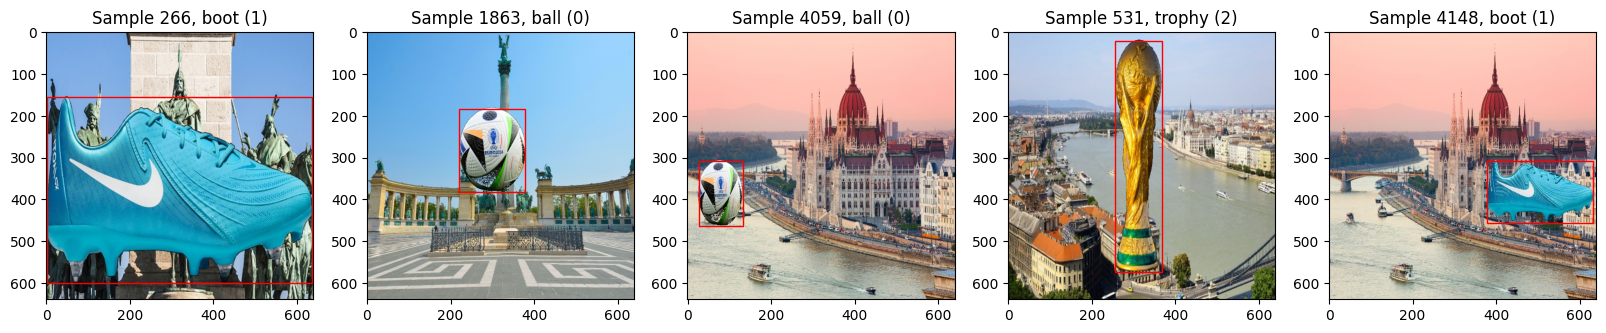

In [20]:
# Show some visualizations of the created dataset
def visualize_dataset(dataset: Dataset):
    samples = 5
    _, axes = plt.subplots(1, samples, figsize=(20,6))
    indices = random.sample(range(len(dataset)), samples)
    for i in range(len(indices)):
        x, y, bounding_box = dataset[indices[i]]
        show_im_w_bbox(bounding_box.unsqueeze(0),['r'], x, axes[i], f'Sample {indices[i]}, {classes_dict[y.item()]} ({int(y)})')
    plt.show()

visualize_dataset(train_dataset)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [22]:
# Here I tried a lot of combinations/permutations of the layers, this seemed the best by experiment
class CustomModel(nn.Module):
    def __init__(self, in_channels: int, num_classes=3):
        super(CustomModel, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d((7, 7))

        self.dense1 = nn.Sequential(
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )

        self.dense2 = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )

        self.classification = nn.Linear(128, num_classes)
        self.regression = nn.Sequential(
            nn.Linear(128, 4),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.dense1(x)
        x = self.dense2(x)
        class_out = self.classification(x)
        bbox_out = self.regression(x)
        return class_out, bbox_out

In [23]:
dummy_image = torch.randn(1, 3, 640, 640).to(device)
num_classes = 3

model = CustomModel(dummy_image.shape[1], num_classes).to(device)
cls_output, bbox_output = model(dummy_image)

print("Class Output Shape:", cls_output.shape)
print("Bounding Box Output Shape:", bbox_output.shape)

Class Output Shape: torch.Size([1, 3])
Bounding Box Output Shape: torch.Size([1, 4])


In [28]:
# Calculating the mAP score, I used the MeanAveragePrecision class, found it on internet. I used the 0.5 threshold, because as the lecture slides said, 0.5 the lowest acceptable iou.
def get_mAP(logits: torch.Tensor, labels: torch.Tensor, logits_class, labels_class, class_probabs=None):
  pred_boxes = []
  if class_probabs is not None:
    class_probabs = torch.max(class_probabs, dim=1)[0]
  for i, (box, cls) in enumerate(zip(logits, logits_class)):
      bbox = yolo_to_coordinates_batches(box.unsqueeze(0), img_size[0], img_size[1])
      pred_boxes.append({
          'boxes': bbox,
          'scores': class_probabs[i].unsqueeze(0) if class_probabs is not None else torch.tensor([0.9]),
          'labels': torch.tensor([cls])
      })
  true_boxes = []
  for box, cls in zip(labels, labels_class):
      bbox = yolo_to_coordinates_batches(box.unsqueeze(0), img_size[0], img_size[1])
      true_boxes.append({
          'boxes': bbox,
          'labels': torch.tensor([cls])
      })
  metric = MeanAveragePrecision(iou_thresholds=[0.5])
  metric.update(pred_boxes, true_boxes)
  mAP_score = metric.compute()
  return mAP_score['map']

In [25]:
# Calculating the Intersection over Union score, here I added the loss parameter, because I trained with this metric as loss function
def iou_loss(logits, labels, img_width, img_height, loss=True):
    logits_coords = yolo_to_coordinates_batches(logits, img_width, img_height)
    labels_coords = yolo_to_coordinates_batches(labels, img_width, img_height)
    logits_x1, logits_y1, logits_x2, logits_y2 = logits_coords[:, 0], logits_coords[:, 1], logits_coords[:, 2], logits_coords[:, 3]
    labels_x1, labels_y1, labels_x2, labels_y2 = labels_coords[:, 0], labels_coords[:, 1], labels_coords[:, 2], labels_coords[:, 3]
    inter_x1 = torch.max(logits_x1, labels_x1)
    inter_y1 = torch.max(logits_y1, labels_y1)
    inter_x2 = torch.min(logits_x2, labels_x2)
    inter_y2 = torch.min(logits_y2, labels_y2)
    inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * torch.clamp(inter_y2 - inter_y1, min=0)
    logits_area = (logits_x2 - logits_x1) * (logits_y2 - logits_y1)
    labels_area = (labels_x2 - labels_x1) * (labels_y2 - labels_y1)
    union_area = logits_area + labels_area - inter_area
    iou = inter_area / torch.clamp(union_area, min=1e-6)
    if loss:
      return (1 - iou).mean()
    else:
      return iou.mean()

In [26]:
# Getting all the metrics in 1 function
def get_metrics(logits_class: torch.Tensor, labels_class: torch.Tensor, logits_bbox: torch.Tensor, labels_bbox: torch.Tensor, class_probabs: torch.Tensor|None = None):
  precision = multiclass_precision(logits_class, labels_class, num_classes=num_classes)
  recall = multiclass_recall(logits_class, labels_class, num_classes=num_classes)
  mAP = get_mAP(logits_bbox, labels_bbox, logits_class, labels_class, class_probabs)
  conf_matrix = confusion_matrix(labels_class, logits_class)
  f1_score = multiclass_f1_score(logits_class, labels_class, num_classes=num_classes)
  iou = iou_loss(logits_bbox, labels_bbox, img_size[0], img_size[1], False)
  return precision, recall, mAP, f1_score, iou, conf_matrix

In [27]:
model_state_dict_path = os.path.join(drive_path, 'model_state_dict.pt')

In [29]:
# The usual training/validation process, one thing to mention is that I used iou loss, because I was trying with MSE, L1 and the loss was descending during the training but somehow
# the bounding boxes were absolutely wrong. I read on the internet to try this loss and it worked.
learning_rate = 0.001
load_model = False
num_epochs = 20
patience = 3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
class_loss_fn = nn.CrossEntropyLoss()
bbox_loss_fn = iou_loss
torch.cuda.empty_cache()
def train_model(model, train_loader, val_loader, optimizer, class_loss_fn, bbox_loss_fn, num_epochs=10, patience = 5):
    train_losses = []
    val_losses = []
    precisions = []
    recalls = []
    f1_scores = []
    mAPs = []
    ious = []
    for epoch in range(num_epochs):
        class_train_loss = []
        reg_train_loss = []
        class_val_loss = []
        reg_val_loss = []
        best_val_loss = np.inf
        bad_val_epochs = 0
        precisions_epoch = []
        recalls_epoch = []
        f1_scores_epoch = []
        mAPs_epoch = []
        ious_epoch= []
        for x_train, y_train, bbox_train in tqdm(train_loader):
            x_train, y_train, bbox_train = x_train.to(device), y_train.to(device), bbox_train.to(device)
            model.train()
            optimizer.zero_grad()
            pred_class, pred_reg = model(x_train)
            class_loss = class_loss_fn(pred_class, y_train)
            reg_loss = bbox_loss_fn(pred_reg, bbox_train, img_size[0], img_size[1])
            total_loss = class_loss * 0.2 + reg_loss * 0.8 # This was also decided by experimenting, the classification part was much easier to learn, so I decided to take this weights
            total_loss.backward()
            optimizer.step()
            class_train_loss.append(class_loss.item())
            reg_train_loss.append(reg_loss.item())
        class_train_loss_mean = np.mean(class_train_loss)
        reg_train_loss_mean = np.mean(reg_train_loss)
        train_losses.append((class_train_loss_mean, reg_train_loss_mean))
        with torch.inference_mode():
            for x_val, y_val, bbox_val in val_loader:
                model.eval()
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                bbox_val = bbox_val.to(device)
                pred_class, pred_reg = model(x_val)
                class_loss = class_loss_fn(pred_class, y_val)
                reg_loss = bbox_loss_fn(pred_reg, bbox_val, img_size[0], img_size[1])
                total_val_loss = class_loss * 0.2 + reg_loss * 0.8
                class_val_loss.append(class_loss.item())
                reg_val_loss.append(reg_loss.item())
                pred_class = torch.softmax(pred_class, 1)
                class_probabs = pred_class.clone()
                pred_class = torch.argmax(pred_class, 1)
                precision_val, recall_val, mAP_val, f1_val, iou, _ = get_metrics(pred_class.cpu(), y_val.cpu(), pred_reg.cpu(), bbox_val.cpu(), class_probabs.cpu())
                precisions_epoch.append(precision_val)
                recalls_epoch.append(recall_val)
                mAPs_epoch.append(mAP_val)
                f1_scores_epoch.append(f1_val)
                ious_epoch.append(iou)
            class_val_loss_mean = np.mean(class_val_loss)
            reg_val_loss_mean = np.mean(reg_val_loss)
            precision_val_mean = np.mean(precisions_epoch)
            recall_val_mean = np.mean(recalls_epoch)
            mAP_val_mean = np.mean(mAPs_epoch)
            f1_val_mean = np.mean(f1_scores_epoch)
            iou_val_mean = np.mean(ious_epoch)
            val_losses.append((class_val_loss_mean, reg_val_loss_mean))
            precisions.append(precision_val_mean)
            recalls.append(recall_val_mean)
            mAPs.append(mAP_val_mean)
            f1_scores.append(f1_val_mean)
            ious.append(iou_val_mean)
        print(f'Epoch: {epoch + 1} | Class train loss: {np.round(class_train_loss_mean, 3)} val loss: {np.round(class_val_loss_mean, 3)} | Reg train loss: {np.round(reg_train_loss_mean, 3)} val loss: {np.round(reg_val_loss_mean, 3)}')
        if best_val_loss > total_val_loss:
            best_val_loss = total_val_loss
            bad_val_epochs = 0
            best_model_wts = model.state_dict()
        else:
            bad_val_epochs += 1
            if bad_val_epochs >= patience:
                print('Early stopping')
                break
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), model_state_dict_path)
    return train_losses, val_losses, precisions, recalls, f1_scores, mAPs, ious
if load_model:
  model.load_state_dict(torch.load(model_state_dict_path, weights_only=True))
else:
  train_losses, val_losses, precisions, recalls, f1_scores, mAPs, ious = train_model(model, train_loader, val_loader, optimizer, class_loss_fn, bbox_loss_fn, num_epochs=num_epochs, patience=patience)

100%|██████████| 157/157 [01:38<00:00,  1.59it/s]


Epoch: 1 | Class train loss: 0.656 val loss: 0.348 | Reg train loss: 0.792 val loss: 0.663


100%|██████████| 157/157 [01:37<00:00,  1.61it/s]


Epoch: 2 | Class train loss: 0.273 val loss: 0.661 | Reg train loss: 0.697 val loss: 0.658


100%|██████████| 157/157 [01:36<00:00,  1.63it/s]


Epoch: 3 | Class train loss: 0.175 val loss: 0.087 | Reg train loss: 0.659 val loss: 0.591


100%|██████████| 157/157 [01:36<00:00,  1.64it/s]


Epoch: 4 | Class train loss: 0.126 val loss: 0.034 | Reg train loss: 0.645 val loss: 0.564


100%|██████████| 157/157 [01:36<00:00,  1.63it/s]


Epoch: 5 | Class train loss: 0.074 val loss: 0.011 | Reg train loss: 0.623 val loss: 0.548


100%|██████████| 157/157 [01:36<00:00,  1.63it/s]


Epoch: 6 | Class train loss: 0.06 val loss: 0.009 | Reg train loss: 0.605 val loss: 0.519


100%|██████████| 157/157 [01:36<00:00,  1.63it/s]


Epoch: 7 | Class train loss: 0.042 val loss: 0.009 | Reg train loss: 0.59 val loss: 0.508


100%|██████████| 157/157 [01:36<00:00,  1.63it/s]


Epoch: 8 | Class train loss: 0.051 val loss: 0.098 | Reg train loss: 0.584 val loss: 0.489


100%|██████████| 157/157 [01:36<00:00,  1.63it/s]


Epoch: 9 | Class train loss: 0.038 val loss: 0.005 | Reg train loss: 0.57 val loss: 0.481


100%|██████████| 157/157 [01:36<00:00,  1.62it/s]


Epoch: 10 | Class train loss: 0.035 val loss: 0.003 | Reg train loss: 0.562 val loss: 0.455


100%|██████████| 157/157 [01:36<00:00,  1.63it/s]


Epoch: 11 | Class train loss: 0.03 val loss: 0.004 | Reg train loss: 0.551 val loss: 0.445


100%|██████████| 157/157 [01:35<00:00,  1.64it/s]


Epoch: 12 | Class train loss: 0.025 val loss: 0.018 | Reg train loss: 0.544 val loss: 0.457


100%|██████████| 157/157 [01:36<00:00,  1.63it/s]


Epoch: 13 | Class train loss: 0.031 val loss: 0.01 | Reg train loss: 0.537 val loss: 0.465


100%|██████████| 157/157 [01:36<00:00,  1.62it/s]


Epoch: 14 | Class train loss: 0.028 val loss: 0.003 | Reg train loss: 0.529 val loss: 0.435


100%|██████████| 157/157 [01:36<00:00,  1.63it/s]


Epoch: 15 | Class train loss: 0.025 val loss: 0.002 | Reg train loss: 0.525 val loss: 0.484


100%|██████████| 157/157 [01:36<00:00,  1.62it/s]


Epoch: 16 | Class train loss: 0.025 val loss: 0.002 | Reg train loss: 0.518 val loss: 0.404


100%|██████████| 157/157 [01:37<00:00,  1.62it/s]


Epoch: 17 | Class train loss: 0.026 val loss: 0.002 | Reg train loss: 0.512 val loss: 0.368


100%|██████████| 157/157 [01:36<00:00,  1.62it/s]


Epoch: 18 | Class train loss: 0.027 val loss: 0.001 | Reg train loss: 0.512 val loss: 0.351


100%|██████████| 157/157 [01:36<00:00,  1.62it/s]


Epoch: 19 | Class train loss: 0.023 val loss: 0.001 | Reg train loss: 0.501 val loss: 0.376


100%|██████████| 157/157 [01:37<00:00,  1.62it/s]


Epoch: 20 | Class train loss: 0.025 val loss: 0.003 | Reg train loss: 0.495 val loss: 0.406


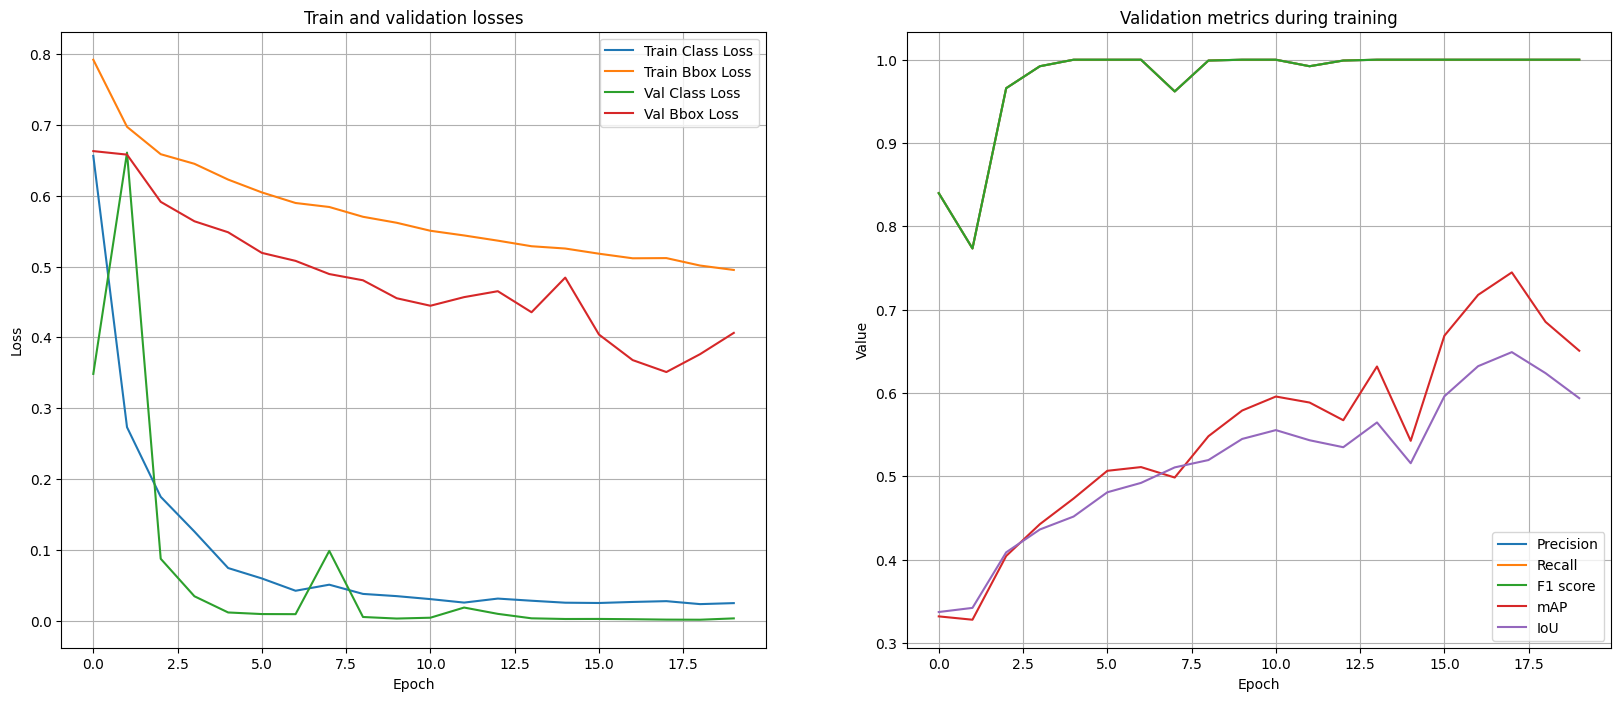

In [30]:
# Training losses and metrics
def plot_training_history(train_losses, val_losses, precisions, recalls, f1_scores, mAPs):
    train_losses_np = np.array(train_losses)
    val_losses_np = np.array(val_losses)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
    ax1.plot(train_losses_np[:, 0], label='Train Class Loss')
    ax1.plot(train_losses_np[:, 1], label='Train Bbox Loss')
    ax1.plot(val_losses_np[:, 0], label='Val Class Loss')
    ax1.plot(val_losses_np[:, 1], label='Val Bbox Loss')
    ax1.set_title('Train and validation losses')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax1.grid()

    ax2.plot(precisions, label='Precision')
    ax2.plot(recalls, label='Recall')
    ax2.plot(f1_scores, label='F1 score')
    ax2.plot(mAPs, label='mAP')
    ax2.plot(ious, label='IoU')
    ax2.grid()
    ax2.set_title('Validation metrics during training')
    ax2.set_ylabel('Value')
    ax2.set_xlabel('Epoch')
    ax2.legend()
plot_training_history(train_losses, val_losses, precisions, recalls, f1_scores, mAPs)

In [31]:
# Getting the whole test dataset predictions to use it below
def get_test_pred(model):
  labels_class = []
  labels_bbox = []
  logits_class = []
  logits_bbox = []
  class_probabs = []
  with torch.inference_mode():
    for x_test, y_test, bbox_test in test_loader:
      x_test, y_test, bbox_test = x_test.to(device), y_test.to(device), bbox_test.to(device)
      class_pred, bbox_pred = model(x_test)
      class_pred = torch.softmax(class_pred, dim=1)
      class_probabs.append(class_pred)
      class_pred = torch.argmax(class_pred, dim = 1)
      labels_class.append(y_test)
      labels_bbox.append(bbox_test)
      logits_class.append(class_pred)
      logits_bbox.append(bbox_pred)
  labels_class = torch.cat(labels_class).cpu()
  labels_bbox = torch.cat(labels_bbox).cpu()
  logits_class = torch.cat(logits_class).cpu()
  logits_bbox = torch.cat(logits_bbox).cpu()
  class_probabs = torch.cat(class_probabs).cpu()
  return labels_class, labels_bbox, logits_class, logits_bbox, class_probabs

In [32]:
test_labels_class, test_labels_bbox, test_logits_class, test_logits_bbox, test_class_probabs = get_test_pred(model)

In [33]:
def evaluate_test_set(labels_class, labels_bbox, logits_class, logits_bbox, class_probabs):
    return get_metrics(logits_class, labels_class, logits_bbox, labels_bbox, class_probabs)
precision, recall, mAP, f1_score, iou, conf_matrix = evaluate_test_set(test_labels_class, test_labels_bbox, test_logits_class, test_logits_bbox, test_class_probabs)

In [34]:
print(f'Evaluate on test dataset:\nPrecision: {np.round(precision.item(),3)}\nRecall: {np.round(recall.item(),3)}\nF1 score: {np.round(f1_score.item(),3)}\nmAP: {np.round(mAP.item(),3)}\nIoU: {np.round(iou.item(),3)}')

Evaluate on test dataset:
Precision: 1.0
Recall: 1.0
F1 score: 1.0
mAP: 0.621
IoU: 0.579


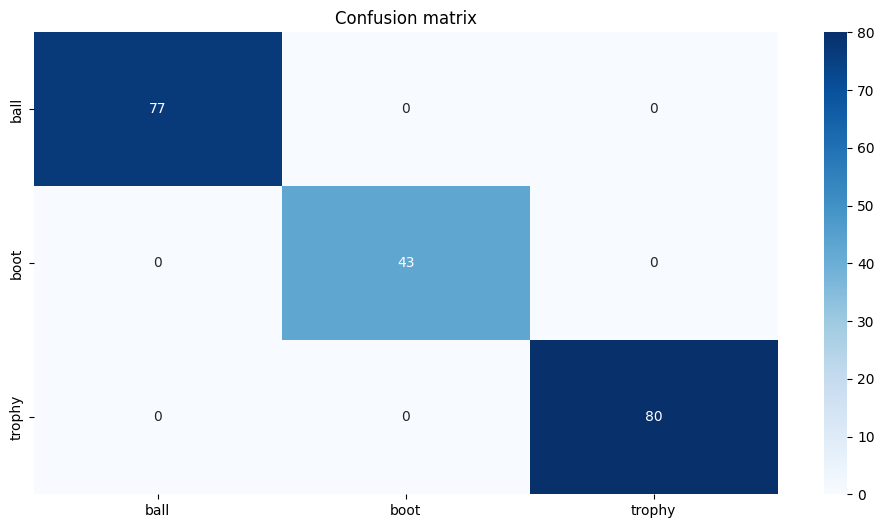

In [35]:
# Confusion matrix of the test dataset
plt.figure(figsize=(12,6))
names = [x[1] for x in sorted(classes_dict.items())]
sns.heatmap(conf_matrix, annot=True, xticklabels = names, yticklabels = names, cmap='Blues')
plt.title('Confusion matrix')
plt.show()

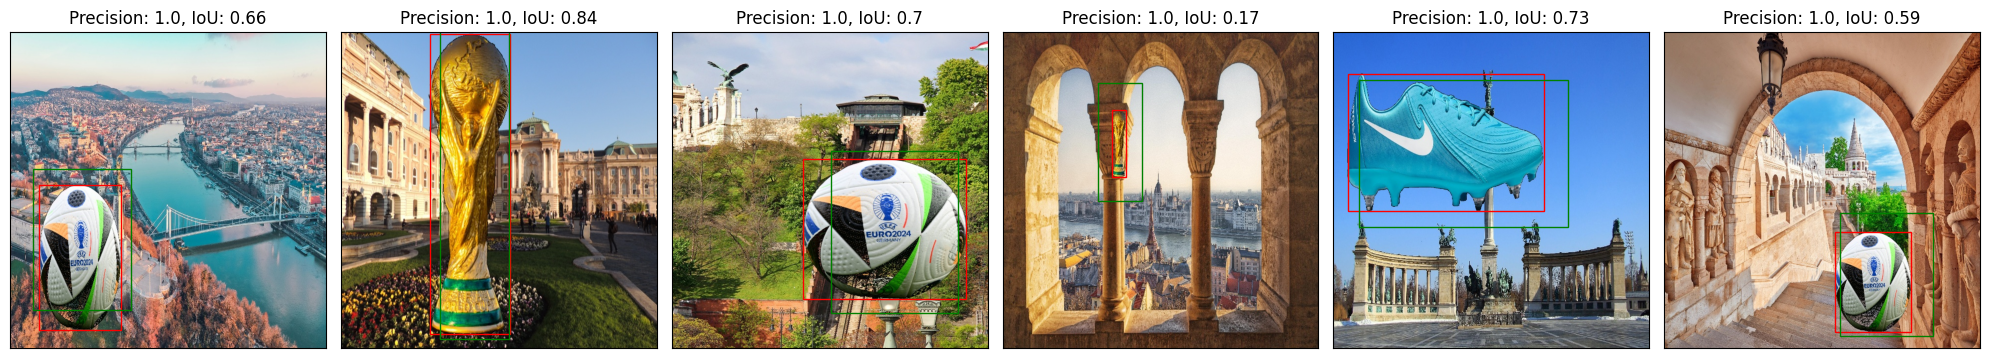

In [36]:
# Visualizing the predictions of the test dataset
def visualize_predictions(logits_class, logits_bbox, labels_class, labels_bbox, test_dataset):
  samples_num = 6
  indices = random.sample(range(len(logits_class)), samples_num)
  precisions = []
  ious = []
  for logit_class, logit_bbox, label_class, label_bbox in zip(logits_class, logits_bbox, labels_class, labels_bbox):
    precision = multiclass_precision(logit_class.unsqueeze(0), label_class.unsqueeze(0))
    precisions.append(precision)
    iou = iou_loss(label_bbox.unsqueeze(0), logit_bbox.unsqueeze(0), img_size[0], img_size[1], False)
    ious.append(iou)


  fig, axes = plt.subplots(1, samples_num, figsize=(20,6))
  for row in range(samples_num):
      ax = axes[row]
      ind = indices[row]
      show_im_w_bbox([labels_bbox[ind], logits_bbox[ind]],['r', 'g'], test_dataset[ind][0], ax, f'Precision: {precisions[ind]}, IoU: {np.round(ious[ind].item(), 2)}')
      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_xticks([])
      ax.set_yticks([])
  plt.tight_layout()
  plt.show()
visualize_predictions(test_logits_class, test_logits_bbox, test_labels_class, test_labels_bbox, test_dataset)

In [37]:
# Getting the data.yaml from drive
!cp '/content/drive/My Drive/DND_assignment_1/data.yaml' '/content/'

In [38]:
load_yolo = False

In [39]:
# Training yolo
if not load_yolo:
  !yolo task=detect mode=train data=data.yaml epochs=5 imgsz=640

100% 5.35M/5.35M [00:00<00:00, 70.4MB/s]
Ultralytics 8.3.13 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

In [40]:
if not load_yolo:
  !cp /content/runs/detect/train/weights/best.pt /content/drive/My\ Drive/DND_assignment_1/

In [41]:
yolo_training_path = 'runs/detect/train'

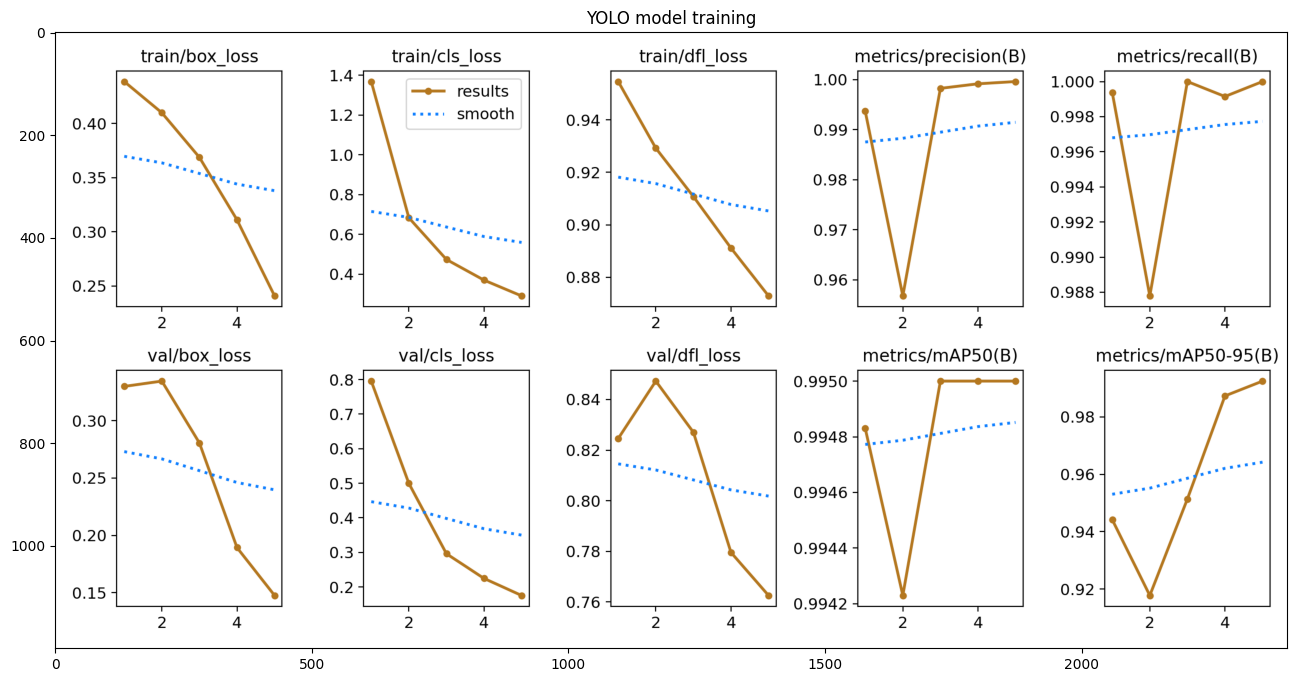

In [42]:
# I plotted from the files that yolo makes during training
yolo_results_path = os.path.join(yolo_training_path, 'results.png')
plt.figure(figsize=(20,8))
plt.imshow(cv2.imread(yolo_results_path))
plt.title('YOLO model training')
plt.show()

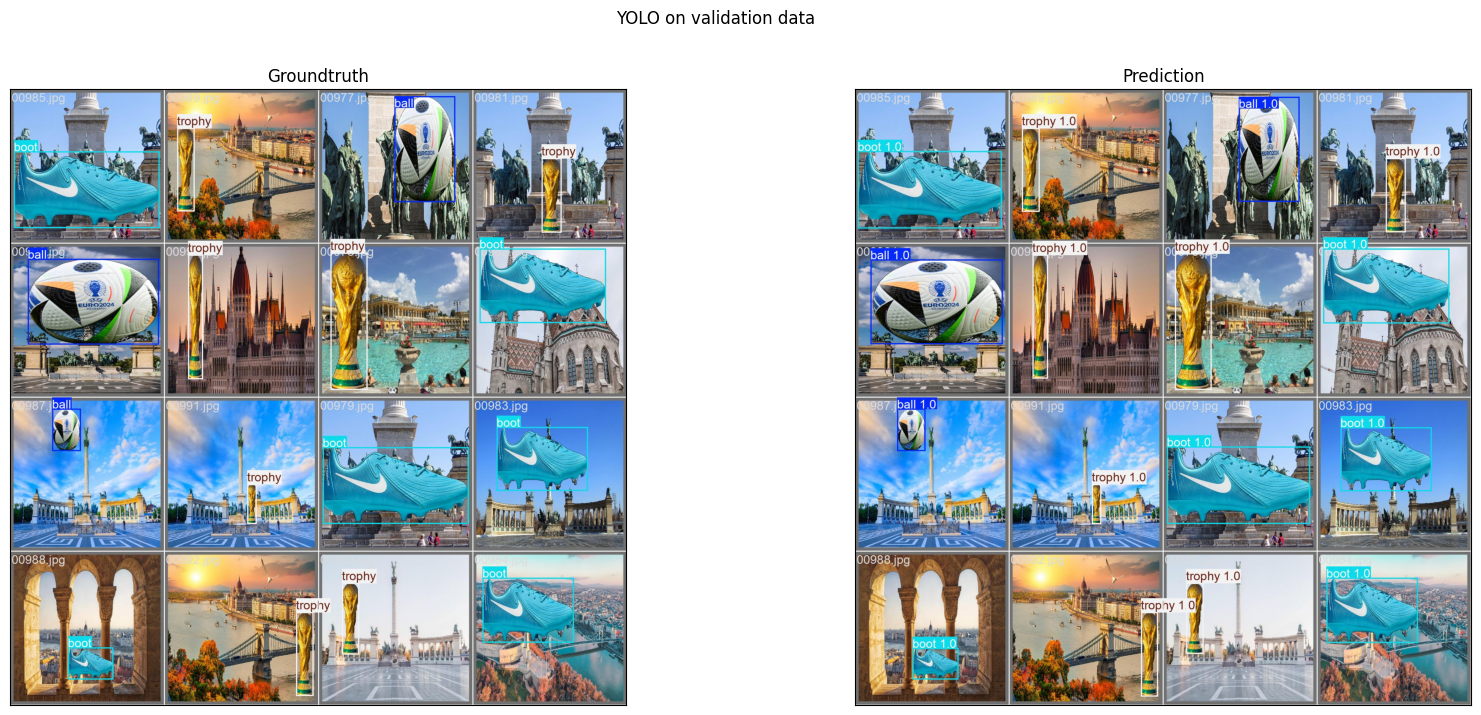

In [43]:
# Showing some predictions from yolo on validation dataset
yolo_val_labels_path = os.path.join(yolo_training_path, 'val_batch0_labels.jpg')
yolo_val_logits_path = os.path.join(yolo_training_path, 'val_batch0_pred.jpg')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
labels_img = cv2.imread(yolo_val_labels_path)
logits_img = cv2.imread(yolo_val_logits_path)
ax1.imshow(cv2.cvtColor(labels_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Groundtruth')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.imshow(cv2.cvtColor(logits_img, cv2.COLOR_BGR2RGB))
ax2.set_title('Prediction')
ax2.set_xticks([])
ax2.set_yticks([])
fig.suptitle('YOLO on validation data')
fig.show()

In [44]:
# Predicting with yolo
if load_yolo:
  !yolo task=detect mode=predict model=/content/drive/My\ Drive/DND_assignment_1/yolo_weights.pt source=/content/dataset/test/images imgsz=640 save_txt=True
else:
  !yolo task=detect mode=predict model=runs/detect/train/weights/best.pt source=/content/dataset/test/images imgsz=640 save_txt=True

Ultralytics 8.3.13 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs

image 1/200 /content/dataset/test/images/00001.jpg: 640x640 1 trophy, 10.3ms
image 2/200 /content/dataset/test/images/00002.jpg: 640x640 1 ball, 10.1ms
image 3/200 /content/dataset/test/images/00003.jpg: 640x640 1 trophy, 9.7ms
image 4/200 /content/dataset/test/images/00004.jpg: 640x640 1 ball, 1 trophy, 9.6ms
image 5/200 /content/dataset/test/images/00005.jpg: 640x640 1 trophy, 9.6ms
image 6/200 /content/dataset/test/images/00006.jpg: 640x640 1 ball, 9.4ms
image 7/200 /content/dataset/test/images/00007.jpg: 640x640 1 boot, 9.4ms
image 8/200 /content/dataset/test/images/00008.jpg: 640x640 1 trophy, 9.7ms
image 9/200 /content/dataset/test/images/00009.jpg: 640x640 1 ball, 9.5ms
image 10/200 /content/dataset/test/images/00010.jpg: 640x640 1 ball, 9.7ms
image 11/200 /content/dataset/test/images/00011.jpg: 640x640

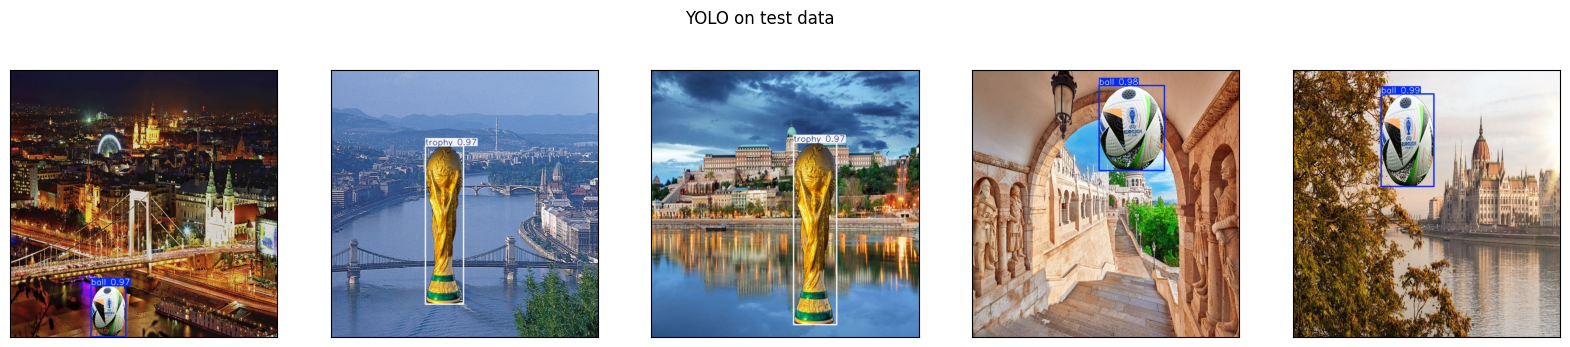

In [45]:
# Show the predictions of yolo on the test dataset
yolo_predict_path = '/content/runs/detect/predict'
files = os.listdir(yolo_predict_path)
samples_num = 5
samples = random.sample(files, samples_num)
fig, axes = plt.subplots(1, samples_num, figsize=(20,4))
for i,sample in enumerate(samples):
  img = cv2.imread(os.path.join(yolo_predict_path, sample))
  ax = axes[i]
  ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  ax.set_xticks([])
  ax.set_yticks([])
fig.suptitle('YOLO on test data')
fig.show()

In [46]:
# Getting the predicted classes, bounding boxes from the prediction files that yolo created
yolo_test_classes = []
yolo_test_bboxes = []
yolo_labels_path = os.path.join(yolo_predict_path, 'labels')
yolo_labels_files = sorted(os.listdir(yolo_labels_path))
for label_file in yolo_labels_files:
  path = os.path.join(yolo_labels_path, label_file)
  with open(path, 'r') as f:
    val = f.read().replace('\n', '')
    val = val.split(' ')
    val = [float(x) for x in val]
    yolo_test_classes.append(int(val[0]))
    yolo_test_bboxes.append([val[1], val[2], val[3], val[4]])
yolo_test_classes = torch.tensor(yolo_test_classes)
yolo_test_bboxes = torch.tensor(yolo_test_bboxes)

In [47]:
yolo_precision, yolo_recall, yolo_mAP, yolo_f1, yolo_iou, yolo_conf_matrix = get_metrics(yolo_test_classes, test_labels_class, yolo_test_bboxes, test_labels_bbox)

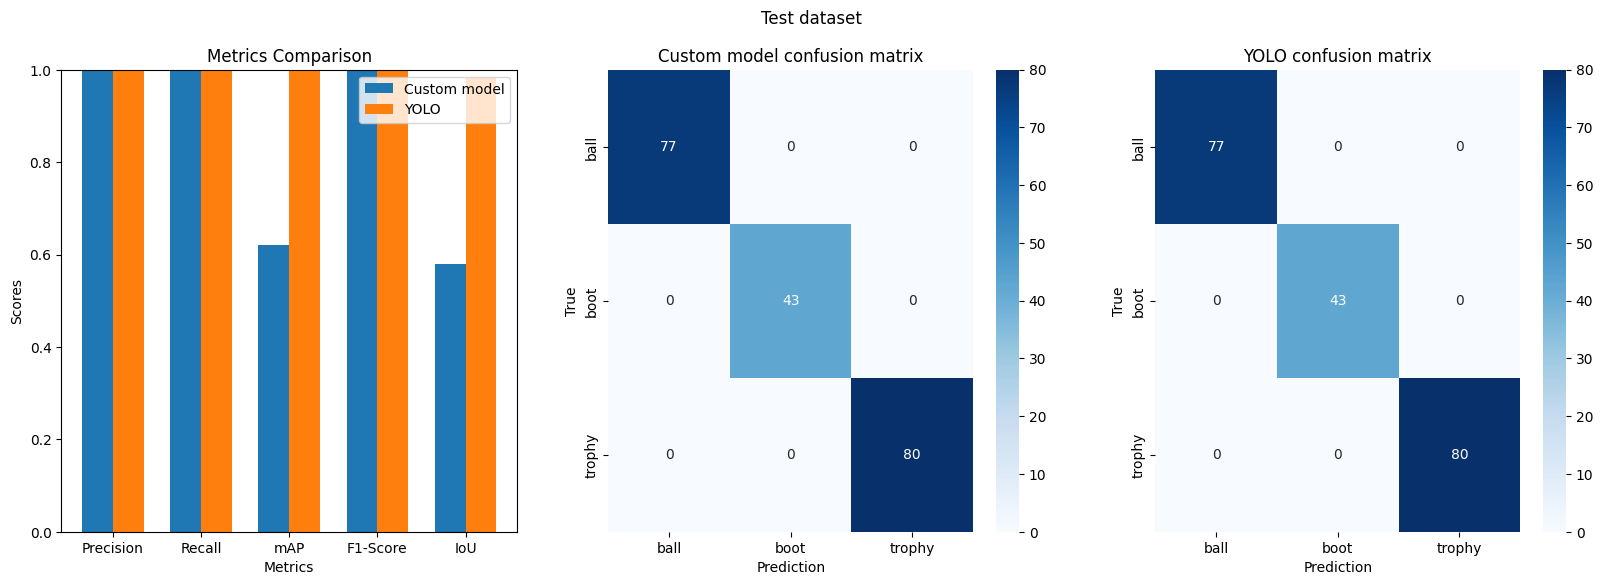

In [48]:
# Some metrics comparison
metrics = ["Precision", "Recall", "mAP", "F1-Score", 'IoU']
custom_model_scores = [precision, recall, mAP, f1_score, iou]
yolo_model_scores = [yolo_precision, yolo_recall, yolo_mAP, yolo_f1, yolo_iou]
x = np.arange(len(metrics))
width = 0.35
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
bars1 = ax1.bar(x - width/2, custom_model_scores, width, label='Custom model')
bars2 = ax1.bar(x + width/2, yolo_model_scores, width, label='YOLO')
ax1.set_xlabel('Metrics')
ax1.set_ylabel('Scores')
ax1.set_title('Metrics Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.set_ylim(0, 1)

names = [x[1] for x in sorted(classes_dict.items())]

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=names, yticklabels=names, ax=ax2)
ax2.set_title("Custom model confusion matrix")
ax2.set_xlabel("Prediction")
ax2.set_ylabel("True")

sns.heatmap(yolo_conf_matrix, annot=True, fmt="d", cmap="Blues",xticklabels=names, yticklabels=names, ax=ax3)
ax3.set_title("YOLO confusion matrix")
ax3.set_xlabel("Prediction")
ax3.set_ylabel("True")
fig.suptitle('Test dataset')
fig.show()

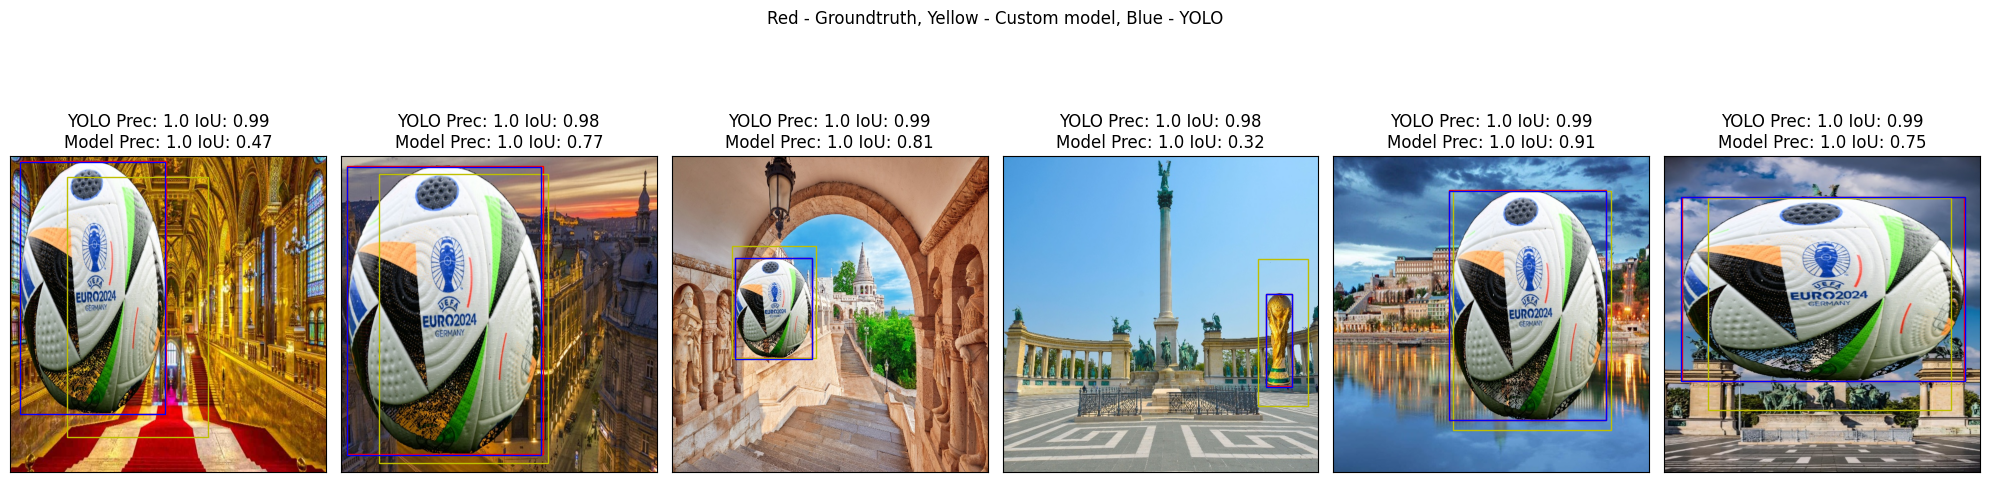

In [50]:
# Show both models' predictions on the test dataset
def visualize_predictions_both_models_test(labels_class, labels_bbox, model_class, model_bbox, yolo_class, yolo_bbox, test_dataset):
  samples_num = 6
  indices = random.sample(range(len(test_dataset)), samples_num)
  labels_class = labels_class[indices]
  labels_bbox = labels_bbox[indices]
  model_class = model_class[indices]
  model_bbox = model_bbox[indices]
  yolo_class = yolo_class[indices]
  yolo_bbox = yolo_bbox[indices]

  def get_scores(labels_class, labels_bbox, logits_class, logits_box):
    precisions = []
    ious = []
    for logit, label in zip(logits_class, labels_class):
      precision = multiclass_precision(logit.unsqueeze(0), label.unsqueeze(0))
      precisions.append(precision)
    for logit, label in zip(logits_box, labels_bbox):
      iou = iou_loss(logit.unsqueeze(0), label.unsqueeze(0), img_size[0], img_size[1], False)
      ious.append(iou)
    return precisions, ious

  precisions_model, ious_model = get_scores(labels_class, labels_bbox, model_class, model_bbox)
  precisions_yolo, ious_yolo = get_scores(labels_class, labels_bbox, yolo_class, yolo_bbox)

  fig, axes = plt.subplots(1, samples_num, figsize=(20,6))
  for row in range(samples_num):
      ax = axes[row]
      show_im_w_bbox([labels_bbox[row], model_bbox[row], yolo_bbox[row]],['r', 'y', 'b'], test_dataset[indices[row]][0], ax, f'YOLO Prec: {precisions_yolo[row]} IoU: {round(ious_yolo[row].item(),2)}\nModel Prec: {precisions_model[row]} IoU: {round(ious_model[row].item(),2)}')
      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_xticks([])
      ax.set_yticks([])
  fig.suptitle('Red - Groundtruth, Yellow - Custom model, Blue - YOLO')
  plt.tight_layout()
  plt.show()
visualize_predictions_both_models_test(test_labels_class, test_labels_bbox, test_logits_class, test_logits_bbox, yolo_test_classes, yolo_test_bboxes, test_dataset)

### The Differences
Yolo was trained on a huge amount of dataset, with some supercomputers and the dataset contained much more types of objects and transfer learning was easier this way so the bounding box part is much stronger with yolo. Also my dataset is very synthetic and yolo's training dataset is real world with much more images. Although I trained for 3 objects the classification part is quite easy for my custom model aswell.

### Improvements
To complete this assigmnent I already did a lot of improvements compared to my first implemented custom model, as I mentioned above, I struggled a lot with the bounding box part, so I tried creating model that has a very simple cnn architecture, then a bit more complex architecture, but the biggest improvement was to change the loss function. Firstly I tried with Mean Squared Error and L1, the loss was descending nicely in the training and in the validation aswell, but somehow the bounding boxes were so wrong and the model did not even get the position of the objects, so I changed the loss to Intersection over Union loss and my model just made a huge improvement. Further improvements would be to use much more backgrounds, and also more data on each dataset. I also played with the learning rate a lot, and 0.001 seemed to be the best, because with 0.01 the losses were almost the same numbers in every epoch, and with 0.0001 it was just too slow to converge.